# Checkpoint 3

Implement here your algorithm to estimate the parametric field from timings recorded in the 20 electrodes of the mapping catheter.

The algorithm should output the following information:
- your estimates of parametric field


In [1]:
import numpy as np
import cvxpy as cvx
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [2]:
!git clone https://github.com/Alepescinaa/ScientificTools
%cd ScientificTools/Project1/Cp3

fatal: destination path 'ScientificTools' already exists and is not an empty directory.
/content/ScientificTools/Project1/Cp3


In [3]:
CP3data = np.load("CP3data.npz")
CP3data = CP3data['arr_0']

CP3estimate = np.load("CP3field.npz")
CP3estimate = CP3estimate['arr_0']

In [4]:
ind_disp = 64
x_meas = CP3data[ind_disp][0]
y_meas = CP3data[ind_disp][1]
t_meas = CP3data[ind_disp][2]

speed_field = CP3estimate[ind_disp][0]

In [5]:
X, Y = np.meshgrid(np.linspace(-1.5,1.5,151), np.linspace(-1.5,1.5,151))

# Find initialization map

In [6]:
index = np.zeros(100)

for i in range(100):
  speed_field = CP3estimate[i][0]

  count = np.sum(speed_field >= 98)
  if count > 0.75 * 151**2:
    index[i] = 1

In [7]:
np.where(index == 1)

(array([64, 87]),)

# SVD and compressed sensing

In [6]:
mesh_size = 151**2
num_samples = 100
A = np.zeros((mesh_size, num_samples))

for i in range(num_samples):
  A[:, i] = CP3estimate[i][0].flatten()

[U,s,V] = np.linalg.svd(A, full_matrices=False)

Text(0.5, 1.0, 'Explained variance')

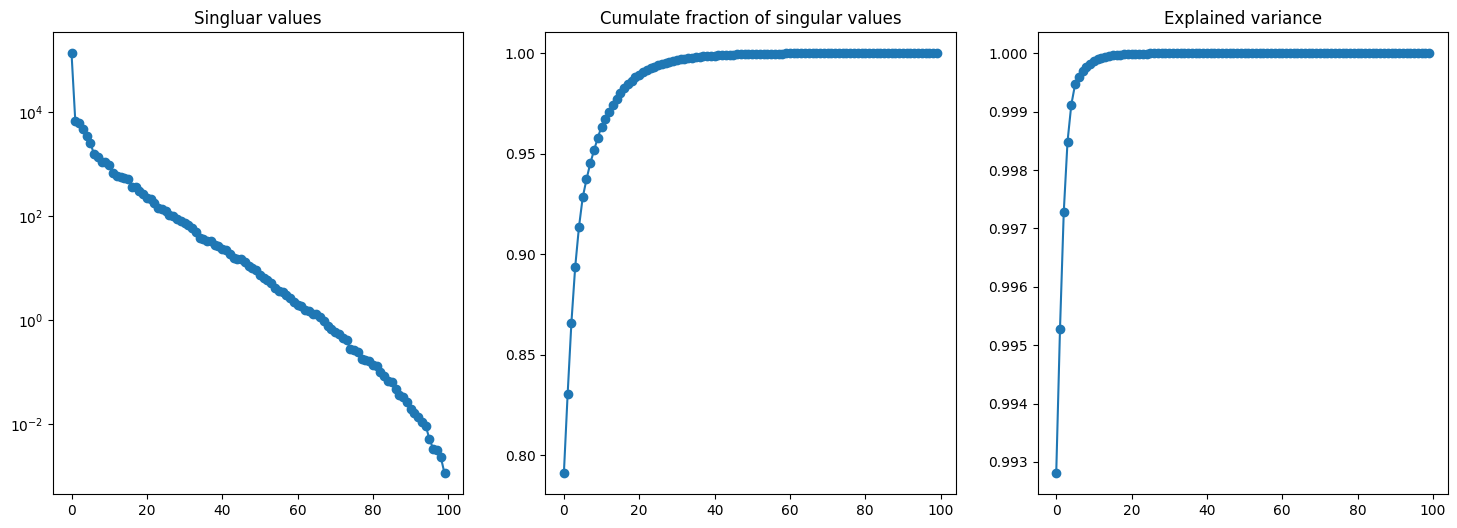

In [7]:
fig, axes = plt.subplots(1, 3, figsize = (18,6))

axes[0].semilogy(s, 'o-')
axes[0].set_title('Singluar values')

axes[1].plot(np.cumsum(s)/np.sum(s), 'o-')
axes[1].set_title('Cumulate fraction of singular values')

axes[2].plot(np.cumsum(s**2)/np.sum(s**2), 'o-')
axes[2].set_title('Explained variance')

Visualization basis functions

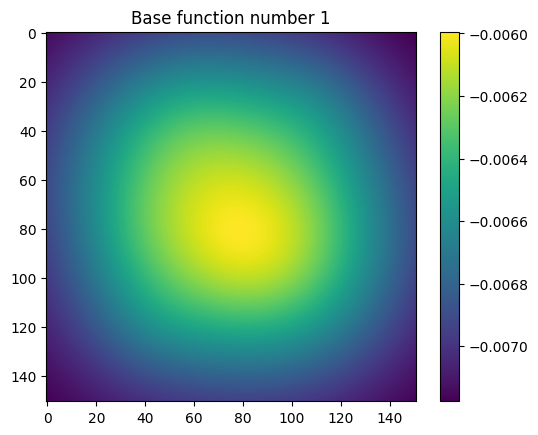

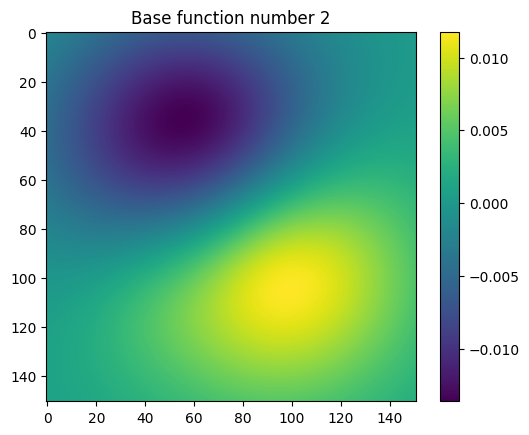

In [10]:
k = 2

for i in range(k):
  U_k = U[:, i].reshape(151, 151)
  plt.imshow(U_k)
  plt.title(f"Base function number {i+1}")
  plt.colorbar()
  plt.show()

In [ ]:
p = 100
perm = np.random.choice(mesh_size, size=p, replace=False)

C = np.zeros((p,mesh_size))
for i in range(p):
    C[i,perm[i]] = 1.0

Theta = C @ U
coeff_mat = np.zeros((5, 100))

for i in range (100):
  u = A[:,i]
  y = C @ u
  s_c = cvx.Variable(U.shape[1])
  constraints = [Theta @ s_c == y]
  obj = cvx.Minimize(cvx.norm(s_c, 1))
  prob = cvx.Problem(obj, constraints)
  prob.solve()
  coeff_mat[:, i] = s_c.value[:5]
  #print("coeff: ", s_c.value[:5])

In [9]:
c1_min, c1_max = np.min(coeff_mat[0, :]), np.max(coeff_mat[0, :])
c2_min, c2_max = np.min(coeff_mat[1, :]), np.max(coeff_mat[1, :])
c3_min, c3_max = np.min(coeff_mat[2, :]), np.max(coeff_mat[2, :])
c4_min, c4_max = np.min(coeff_mat[3, :]), np.max(coeff_mat[3, :])
c5_min, c5_max = np.min(coeff_mat[4, :]), np.max(coeff_mat[4, :])

delta_c1 = c1_max - c1_min
delta_c2 = c2_max - c2_min
delta_c3 = c3_max - c3_min
delta_c4 = c4_max - c4_min
delta_c5 = c5_max - c5_min

print(f"c1 in ({c1_min}, {c1_max})")
print(f"c2 in ({c2_min}, {c2_max})")
print(f"c3 in ({c3_min}, {c3_max})")
print(f"c4 in ({c4_min}, {c4_max})")
print(f"c5 in ({c5_min}, {c5_max})")

c1 in (-14901.761280897084, -12144.02690824246)
c2 in (-1643.3528960732024, 1582.2154727789152)
c3 in (-1666.6210442835466, 1707.6146862198734)
c4 in (-776.3216938104439, 1280.5855881404918)
c5 in (-1093.9742831820113, 1047.5994177035839)


In [29]:
k=5
basis = U[:, :k]

# Inizialization velocity

In [53]:
from scipy.interpolate import RBFInterpolator

def checkpoint1_solution_bis(x, y, t, X, Y, s_value=0.05, s_aniso_1=0.5, s_aniso_2=0.5):
    coordinates = np.column_stack((x, y))

    mesh_coordinates=np.column_stack((X.ravel(), Y.ravel()))

    s = [s_value,s_value,s_value,s_value,s_value,s_value,s_value,s_value,s_value,s_value,s_aniso_1, s_value,s_value,s_value,s_value, s_aniso_2,s_value,s_value,s_value,s_value]

    rbf = RBFInterpolator(coordinates, t, neighbors=None, smoothing=s, kernel='thin_plate_spline', epsilon=None, degree=1)

    time_pred = rbf(mesh_coordinates)
    time_pred=time_pred.reshape(151,151)

    grad_x, grad_y = np.gradient(time_pred)

    vel_pred = 1.0/( np.sqrt((grad_x/(3.0/150))**2+(grad_y/(3.0/150))**2) + 1e-4)
    treshold=160
    if np.max(vel_pred)>treshold:
      source_indices = np.where(vel_pred >treshold)
      indices_2d = np.array(source_indices).T
      vel_pred[indices_2d[:, 0],indices_2d[:, 1]] = 1.0/( np.sqrt((grad_x[indices_2d[:, 0],indices_2d[:, 1]]/(3.0/150))**2+(grad_y[indices_2d[:, 0],indices_2d[:, 1]]/(3.0/150))**2) + 1e-3)
      vel_pred=vel_pred*(vel_pred<treshold)+treshold*(vel_pred>treshold)

    return time_pred, vel_pred

In [54]:
time_pred,vel_pred=checkpoint1_solution_bis(x_meas,y_meas,t_meas,X,Y)
vel_pred=vel_pred.flatten()
coeff_estimation=basis.T@vel_pred

In [55]:
coeff_estimation


array([-14553.83129556,  -2959.01492918])

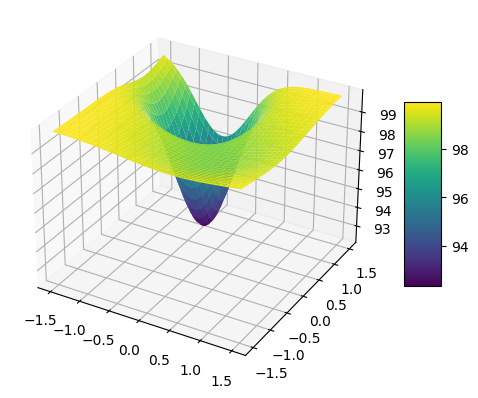

In [28]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X,Y,speed_field.reshape(151,151), cmap='viridis')
ax.axes.set_zlim3d(bottom=np.min(speed_field.reshape(151,151)), top=np.max(speed_field.reshape(151,151)))
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

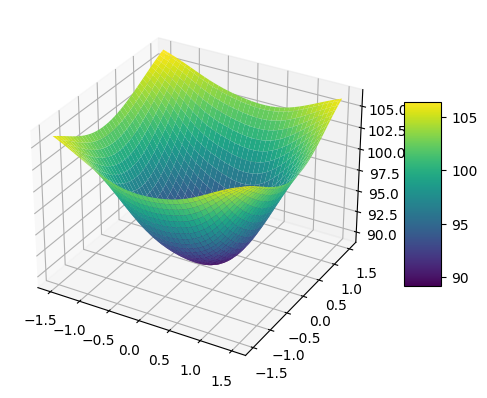

In [27]:
speed_field_estimate=tf.reshape(speed_field_estimate,[151,151])
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X,Y,speed_field_estimate, cmap='viridis')
ax.axes.set_zlim3d(bottom=np.min(speed_field_estimate), top=np.max(speed_field_estimate))
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

# PINN

In [30]:
import scipy.io
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from mpl_toolkits.axes_grid1 import make_axes_locatable

!pip -q install pyDOE
from pyDOE import lhs

# set seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

In [31]:
# collocation points
Ncl = 151**2
Xcl = lhs(2,Ncl)
xcl = tf.expand_dims(tf.cast(-1.5+(3.0)*Xcl[:,0],dtype=tf.float64),axis=-1)
ycl = tf.expand_dims(tf.cast(-1.5+(3.0)*Xcl[:,1],dtype=tf.float64),axis=-1)
X_coll = tf.concat([xcl,ycl],1)

In [34]:
def penalty(param, lower_bound, upper_bound):
    return tf.reduce_sum(tf.square(tf.maximum(param - upper_bound, 0)) +
                         tf.square(tf.maximum(lower_bound - param, 0)))

# PINN loss function
def loss(xcl,ycl,xmeas,ymeas,umeas,coeff):
    input_data=tf.concat([xmeas,ymeas],1)
    umeas_pred = PINN(input_data)
    r_pred   = r_PINN(xcl,ycl,coeff)

    # loss components
    mse_meas  = tf.reduce_mean(tf.pow(umeas-umeas_pred,2))
    mse_r  = tf.reduce_mean(tf.abs(r_pred))

    # bc
    y0 = tf.constant([-0.50784787],dtype=tf.float64)
    mse_bc= tf.pow( PINN( tf.transpose( tf.stack( [tf.constant([1.5],dtype=tf.float64), y0] ) ) ) ,2)

    #penalty
    mse_penalty = penalty(coeff[0],0,1)+penalty(coeff[1],0,1)+penalty(coeff[2],0,1)

    return mse_meas + mse_r + mse_bc + mse_penalty

def loss2(xcl,ycl,xmeas,ymeas,umeas):
    input_data=tf.concat([xmeas,ymeas],1)
    umeas_pred = PINN(input_data)
    r_pred   = r_PINN2(xcl,ycl)

    # loss components
    mse_meas  = tf.reduce_mean(tf.pow(umeas-umeas_pred,2))
    mse_r  = tf.reduce_mean(tf.abs(r_pred))

    # bc
    y0 = tf.constant([-0.50784787],dtype=tf.float64)
    mse_bc= tf.pow( PINN( tf.transpose( tf.stack( [tf.constant([1.5],dtype=tf.float64), y0] ) ) ) ,2)

    return mse_meas + mse_r + mse_bc


@tf.function
def r_PINN(x,y,coeff):
    input_data=tf.concat([x,y],1)
    u = PINN(input_data)
    u_x = tf.gradients(u,x)[0]
    u_y = tf.gradients(u,y)[0]
    u_grad = tf.transpose(tf.concat([u_x, u_y], axis=1))

    pi = tf.constant(np.pi,dtype=tf.float64)
    theta_fiber = tf.constant([0.11629039] ,dtype=tf.float64)
    a_ratio = tf.constant([5.26792418], dtype=tf.float64)
    theta0 = pi/2 - theta_fiber

    a = tf.stack([tf.cos(theta0), tf.sin(theta0)])
    b = tf.stack([tf.cos(theta0-pi/2), tf.sin(theta0-pi/2)])

    D_00 = 1 / a_ratio * a[0]**2 + b[0]**2
    D_01 = 1 / a_ratio * a[0] * a[1] + b[0] * b[1]
    D_10 = 1 / a_ratio * a[0] * a[1] + b[0] * b[1]
    D_11 = 1 / a_ratio * a[1]**2 + b[1]**2

    c1 = c1_min + delta_c1 * coeff[0]
    c2 = c2_min + delta_c2 * coeff[1]
    c3 = c3_min + delta_c3 * coeff[2]
    c4 = c4_min + delta_c4 * coeff[3]
    c5 = c5_min + delta_c5 * coeff[4]

    coeff_true = tf.expand_dims(tf.concat([c1,c2,c3,c4,c5], 0), 1)

    return   (((u_x * D_00 * u_x + u_x * D_01 * u_y + u_y * D_10 * u_x + u_y * D_11 * u_y)))  - (1/(basis@coeff_true))**2

@tf.function
def r_PINN2(x,y):
    input_data=tf.concat([x,y],1)
    u = PINN(input_data)
    u_x = tf.gradients(u,x)[0]
    u_y = tf.gradients(u,y)[0]
    u_grad = tf.transpose(tf.concat([u_x, u_y], axis=1))

    pi = tf.constant(np.pi,dtype=tf.float64)
    theta_fiber = tf.constant([0.11629039] ,dtype=tf.float64)
    a_ratio = tf.constant([5.26792418], dtype=tf.float64)
    theta0 = pi/2 - theta_fiber

    a = tf.stack([tf.cos(theta0), tf.sin(theta0)])
    b = tf.stack([tf.cos(theta0-pi/2), tf.sin(theta0-pi/2)])

    D_00 = 1 / a_ratio * a[0]**2 + b[0]**2
    D_01 = 1 / a_ratio * a[0] * a[1] + b[0] * b[1]
    D_10 = 1 / a_ratio * a[0] * a[1] + b[0] * b[1]
    D_11 = 1 / a_ratio * a[1]**2 + b[1]**2

    return  (((u_x * D_00 * u_x + u_x * D_01 * u_y + u_y * D_10 * u_x + u_y * D_11 * u_y)))  - (1/100)**2


# neural network weight gradients
@tf.function
def grad(model,xcl,ycl,xmeas,ymeas,umeas,coeff):
    with tf.GradientTape(persistent=True) as tape:
        loss_value = loss(xcl,ycl,xmeas,ymeas,umeas,coeff)
        grads = tape.gradient(loss_value,model.trainable_variables)
        grads_weight= tape.gradient(loss_value,coeff)
    return loss_value, grads, grads_weight
    # neural network weight gradients

@tf.function
def grad2(model,xcl,ycl,xmeas,ymeas,umeas):
    with tf.GradientTape(persistent=True) as tape:
        loss_value2 = loss2(xcl,ycl,xmeas,ymeas,umeas)
        grads2 = tape.gradient(loss_value2,model.trainable_variables)
    return loss_value2, grads2

In [35]:
from tensorflow.keras import regularizers
from tensorflow.keras.layers import LSTM

regularization_strength = 1e-3

PINN = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(2,),
                          kernel_initializer="glorot_uniform",
                          kernel_regularizer=regularizers.l2(regularization_strength),
                          dtype=tf.float64),
    #tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Reshape((1, 64)),

    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units = 64)),

    tf.keras.layers.Dense(128, activation='relu',
                          kernel_initializer="glorot_uniform",
                          kernel_regularizer=regularizers.l2(regularization_strength),
                          dtype=tf.float64),
    #tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Dense(32, activation='relu',
                          kernel_initializer="glorot_uniform",
                          kernel_regularizer=regularizers.l2(regularization_strength),
                          dtype=tf.float64),
    #tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Dense(1, activation=None,
                          kernel_initializer="glorot_uniform",
                          kernel_regularizer=regularizers.l2(regularization_strength),
                          dtype=tf.float64)
])

In [ ]:
#selected values  [0.10337211, 4.95760936, -0.50074575]  [0.12920869, 5.57823901, -0.51495002]
print((0.10337211+0.12920869)/2, ( 4.95760936+5.57823901)/2, (-0.50074575+-0.5149500)/2)

0.11629039999999999 5.267924185 -0.507847875


In [38]:
def checkpoint2_solution( x, y , t ):

  xmeas_train, xmeas_val, ymeas_train, ymeas_val, tmeas_train, tmeas_val = train_test_split(x, y, t, test_size=0.05)
  xmeas_train = tf.constant(xmeas_train.reshape(19, 1), dtype=tf.float64)
  ymeas_train = tf.constant(ymeas_train.reshape(19, 1), dtype=tf.float64)
  tmeas_train = tf.constant(tmeas_train.reshape(19, 1), dtype=tf.float64)
  xmeas_val = tf.constant(xmeas_val.reshape(1, 1), dtype=tf.float64)
  ymeas_val = tf.constant(ymeas_val.reshape(1, 1), dtype=tf.float64)
  tmeas_val = tf.constant(tmeas_val.reshape(1, 1), dtype=tf.float64)

  X, Y = np.meshgrid(np.linspace(-1.5,1.5,151), np.linspace(-1.5,1.5,151))


  coeff=tf.Variable([[0.5],[0.5],[0.5],[0.5],[0.5]], trainable=True, dtype=tf.float64)

  tf_optimizer_PINN = tf.keras.optimizers.Adam(learning_rate=0.01,beta_1=0.99)
  tf_optimizer_weights = tf.keras.optimizers.Adam(learning_rate=0.01,beta_1=0.99)

  """
  patience = float('inf')
  patience_lr= float('inf')
  min_delta = 1e-9
  best_val_loss = float('inf')
  wait = 0
  count = 0
  """

  print()

  for iter in range(2000):

    loss_value2,grads2 = grad2(PINN,xcl,ycl,xmeas_train, ymeas_train, tmeas_train)

    tf_optimizer_PINN.apply_gradients(zip(grads2,PINN.trainable_variables))

    loss_value_val2, _= grad2(PINN, xcl, ycl, xmeas_val, ymeas_val, tmeas_val)


    if ((iter+1) % 100 == 0):
      print('iter =  '+str(iter+1))
      tf.print('loss =' , loss_value2)
      tf.print('loss_val_param =' , loss_value_val2)

      c1 = c1_min + delta_c1 * coeff[0]
      c2 = c2_min + delta_c2 * coeff[1]
      c3 = c3_min + delta_c3 * coeff[2]
      c4 = c4_min + delta_c4 * coeff[3]
      c5 = c5_min + delta_c5 * coeff[4]

      coeff_true = tf.expand_dims(tf.concat([c1,c2,c3,c4,c5],0), 1)
      print(coeff_true.numpy())
      print()


  for iter in range(4000):

    loss_value,grads,grads_coeff = grad(PINN,xcl,ycl,xmeas_train, ymeas_train, tmeas_train,coeff)

    tf_optimizer_PINN.apply_gradients(zip(grads ,PINN.trainable_variables ))
    tf_optimizer_weights.apply_gradients(zip([grads_coeff], [coeff]))

    loss_value_val, _, _ = grad(PINN, xcl, ycl, xmeas_val, ymeas_val, tmeas_val,coeff)

    """
    best_weigths = None
    best_params = None

    # Early stopping
    if loss_value_val < best_val_loss - min_delta:
        best_val_loss = loss_value_val
        wait = 0
        count = 0
        best_weights = PINN.get_weights()
        best_params = theta_fiber.numpy()
    else:
        wait += 1
        count += 1

        if count >= patience_lr:
          tf_optimizer.learning_rate = tf_optimizer.learning_rate * 0.9
          count = 0

        if wait >= patience:
            print('Early stopping at epoch', iter + 1)
            break
    """


    if ((iter+1) % 100 == 0):
      print('iter =  '+str(iter+1))
      tf.print('loss =' , loss_value)
      tf.print('loss_val_param =' , loss_value_val)

      c1 = c1_min + delta_c1 * coeff[0]
      c2 = c2_min + delta_c2 * coeff[1]
      c3 = c3_min + delta_c3 * coeff[2]
      c4 = c4_min + delta_c4 * coeff[3]
      c5 = c5_min + delta_c5 * coeff[4]

      coeff_true = tf.expand_dims(tf.concat([c1,c2,c3,c4,c5],0), 1)
      print(coeff_true.numpy())
      print()

  return coeff_true

In [ ]:
weights = checkpoint2_solution(x_meas, y_meas , t_meas)


iter =  100
loss = [[9.9282786258972279e-05]]
loss_val_param = [[8.5573561715468832e-05]]
[[-13522.89409457]
 [   -30.56871165]
 [    20.49682097]
 [   252.13194717]
 [   -23.18743274]]

iter =  200
loss = [[3.1342344418351043e-05]]
loss_val_param = [[3.5567322824316195e-05]]
[[-13522.89409457]
 [   -30.56871165]
 [    20.49682097]
 [   252.13194717]
 [   -23.18743274]]

iter =  300
loss = [[2.4589646081691078e-05]]
loss_val_param = [[5.8650015177745077e-05]]
[[-13522.89409457]
 [   -30.56871165]
 [    20.49682097]
 [   252.13194717]
 [   -23.18743274]]

iter =  400
loss = [[1.7692682146901949e-05]]
loss_val_param = [[1.9674889882199604e-05]]
[[-13522.89409457]
 [   -30.56871165]
 [    20.49682097]
 [   252.13194717]
 [   -23.18743274]]

iter =  500
loss = [[7.1610210894579427e-06]]
loss_val_param = [[8.6596948100047323e-06]]
[[-13522.89409457]
 [   -30.56871165]
 [    20.49682097]
 [   252.13194717]
 [   -23.18743274]]

iter =  600
loss = [[4.0987133651042549e-06]]
loss_val_param = [

In [20]:
speed_field_estimate=basis@weights
speed_field=speed_field.flatten()
mse=np.sqrt(np.mean((speed_field-speed_field_estimate)**2))
mse

4.802717922018558

In [73]:
speed_field

array([99.79581275, 99.78100609, 99.76526202, ..., 99.17319289,
       99.18622773, 99.19952065])

In [21]:
speed_field_estimate

<tf.Tensor: shape=(22801, 1), dtype=float64, numpy=
array([[106.03634318],
       [105.97356422],
       [105.90958516],
       ...,
       [106.05758587],
       [106.11384107],
       [106.16901534]])>

# KERNEL PCA

In [ ]:
import numpy as np
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import StandardScaler


mesh_size = 151 ** 2
num_samples = 100
A = np.zeros((mesh_size, num_samples))

for i in range(num_samples):
  A[:, i] = CP3estimate[i][0].flatten()

scaler = StandardScaler()
data_normalized = scaler.fit_transform(A)


kpca = KernelPCA(kernel='linear', n_components=3, fit_inverse_transform=True)
data_kpca = kpca.fit_transform(data_normalized)

data_rec=kpca.inverse_transform(data_kpca)
data_rec_scaled = scaler.inverse_transform(data_rec)


import matplotlib.pyplot as plt

# Plot the original speed field
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(speed_field, cmap='viridis')
plt.title('Original Speed Field')
plt.colorbar()

# Plot the reconstructed data
plt.subplot(1, 2, 2)
plt.imshow(data_rec_scaled, cmap='viridis')
plt.title('Reconstructed Data')
plt.colorbar()

plt.tight_layout()
plt.show()



# AUTOENCODER

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

latent_dim = 5

mesh_size = 151 ** 2
num_samples = 100
A = np.zeros((mesh_size, num_samples))

for i in range(num_samples):
  A[:, i] = CP3estimate[i][0].flatten()

scaler = StandardScaler()
data_normalized = scaler.fit_transform(A)

input_data = Input(shape=(mesh_size,))
encoded = Dense(latent_dim, activation=None)(input_data)
decoded = Dense(mesh_size, activation=None)(encoded)

# Create the autoencoder model
autoencoder = Model(input_data, decoded)

# Compile the autoencoder model
autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder
autoencoder.fit(data_normalized.T, data_normalized.T, epochs=500, batch_size=32)

# Extract the encoder part to get the latent representation
encoder = Model(input_data, encoded)


In [ ]:
latent_representations = encoder.predict(data_normalized.T)

reconstructed_A = autoencoder.predict(data_normalized.T)
reconstructed_A_rescaled = scaler.inverse_transform(reconstructed_A.T)

In [ ]:
latent_representations


In [ ]:

import matplotlib.pyplot as plt

# Plot the original speed field
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(A[:,10].reshape(151,151), cmap='viridis')
plt.title('Original Speed Field')
plt.colorbar()

# Plot the reconstructed data
plt.subplot(1, 2, 2)
plt.imshow(reconstructed_A_rescaled[:,10].reshape(151,151), cmap='viridis')
plt.title('Reconstructed Data')
plt.colorbar()

plt.tight_layout()
plt.show()